#### 본격적인 경기 분석 메뉴입니다.
#### 팀별 공격 스퀀스를 시각화 합니다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.plot_utils import draw_pitch

분석을 희망하는 리그의 이름을 dataset_name에 할당해주세요.
* ex) England, European_Championship, France, Germany, Italy, Spain, World_Cup
<br>
<br>
분석 희망 데이터 찾기.ipynb를 통해 찾은 match_id를 match_id에 할당해주세요.

In [2]:
match_id = 2058017
dataset_name = 'World_Cup'

In [3]:
match_events = pd.read_pickle(f'data/refined_events/{dataset_name}/{match_id}.pkl')
match_events

,match_id,event_id,period,time,team_id,team_name,player_id,player_name,event_type,sub_event_type,tags,start_x,start_y,end_x,end_y
0,2058017,263883958,1H,1.892,9598,Croatia,14943,M. Mandžukić,Pass,Simple pass,[],52.00,33.32,NaN,NaN
1,2058017,263883959,1H,3.889,9598,Croatia,69968,M. Brozović,Pass,Simple pass,[Accurate],40.56,32.64,35.36,17.68
2,2058017,263883960,1H,6.141,9598,Croatia,8287,L. Modrić,Pass,Simple pass,[Accurate],35.36,17.68,31.20,4.76
3,2058017,263883963,1H,9.227,9598,Croatia,69409,Š. Vrsaljko,Pass,Simple pass,[Accurate],31.20,4.76,11.44,23.80
4,2058017,263883964,1H,12.659,9598,Croatia,135747,D. Subašić,Pass,Launch,[Accurate],11.44,23.80,66.56,33.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2058017,263885652,2H,2978.302,9598,Croatia,3476,I. Rakitić,Pass,Simple pass,[Accurate],47.84,54.40,66.56,63.92
1468,2058017,263885653,2H,2979.085,9598,Croatia,14812,I. Perišić,Others on the ball,Touch,[],66.56,63.92,85.28,66.64
1469,2058017,263885654,2H,2983.449,9598,Croatia,14812,I. Perišić,Pass,Cross,"[Left foot, High, Not accurate]",85.28,66.64,104.00,34.00
1470,2058017,263885613,2H,2985.869,4418,France,25381,H. Lloris,Goalkeeper leaving line,Goalkeeper leaving line,[],0.00,34.00,14.56,38.76


위치와 무관한 데이터 제외 및 원정팀 공격방향 회전 (무시하고 사용하시면 됩니다.)

In [4]:
match_events['display_time'] = match_events.apply(
    lambda x: f"{x['period']} {int(x['time'] // 60):02d}:{int(x['time'] % 60):02d}", axis=1
)
cols = ['period', 'time', 'display_time', 'team_name', 'player_name'] + match_events.columns[8:-1].tolist()
match_events = match_events[match_events['event_type'] != 'Substitution'][cols]

team1_name, team2_name = match_events['team_name'].unique()
team2_x = match_events.loc[match_events['team_name'] == team2_name, ['start_x', 'end_x']]
team2_y = match_events.loc[match_events['team_name'] == team2_name, ['start_y', 'end_y']]
match_events.loc[match_events['team_name'] == team2_name, ['start_x', 'end_x']] = 104 - team2_x
match_events.loc[match_events['team_name'] == team2_name, ['start_y', 'end_y']] = 68 - team2_y

경합 과정에 대한 처리(무시하고 실행하면 됩니다.)

In [5]:
first_idx = 20
last_idx = 30
seq_events = match_events.loc[first_idx:last_idx]

duels = seq_events[seq_events['event_type'] == 'Duel']
duels[['time', 'start_x', 'start_y']].round(3).diff().shift(-1)
diffs = duels[['time', 'start_x', 'start_y']].round(3).diff().shift(-1).fillna(10).abs().sum(axis=1)
diffs



28     0.0
29    30.0
dtype: float64

거의 다 왔습니다. 실행해주세요!

In [15]:
def visualize_sequence(match_events, first_idx, last_idx, title=None, filename=None, rotate_team2_events=False):
    cols = [
        'period', 'time', 'display_time', 'team_name', 'player_name',
        'event_type', 'sub_event_type', 'tags', 'start_x', 'start_y', 'end_x', 'end_y'
    ]
    match_events = match_events[match_events['event_type'] != 'Substitution'][cols]

    team1_name, team2_name = match_events['team_name'].unique()

    seq_events = match_events.loc[first_idx:last_idx].copy()
    if rotate_team2_events:
        team2_idx = seq_events['team_name'] == team2_name
        seq_events.loc[team2_idx, ['start_x', 'end_x']] = 104 - seq_events.loc[team2_idx, ['start_x', 'end_x']]
        seq_events.loc[team2_idx, ['start_y', 'end_y']] = 68 - seq_events.loc[team2_idx, ['start_y', 'end_y']]

    duels = seq_events[seq_events['event_type'] == 'Duel']
    diffs = duels[['time', 'start_x', 'start_y']].diff().shift(-1).fillna(10).abs().sum(axis=1)
    seq_events_plotted = seq_events.drop(index=duels[diffs < 2].index)
    seq_events_plotted.loc[seq_events_plotted['event_type'] == 'Duel', 'team_name'] = 'Duel'

    draw_pitch('white', 'black')

    color_dict = {team1_name: 'red', team2_name: 'blue', 'Duel': 'black'}
    colors = seq_events_plotted['team_name'].apply(lambda x: color_dict[x])
    plt.scatter(seq_events_plotted['start_x'], seq_events_plotted['start_y'], c=colors, s=400)

    for i, event in seq_events_plotted.iterrows():
        x = event['start_x']
        y = event['start_y']
        plt.annotate(i % 100, xy=[x, y], color='white', ha='center', va='center', fontsize=15)
        if not np.isnan(event['end_x']):
            dx = event['end_x'] - x
            dy = event['end_y'] - y
            color = color_dict[event['team_name']]
            plt.arrow(x, y, dx, dy, width=0.3, head_width=1.5, length_includes_head=True, color=color, alpha=0.5)

    if title is None:
        title = seq_events['display_time'].iloc[-1]
    plt.title(title, fontdict={'size': 20})
    
    if filename is not None:
        plt.savefig(f'img/{filename}', bbox_inches='tight')

    plt.show()
    return seq_events[seq_events.columns[2:-4]]

각 팀 공격 시퀀스 검출 코드(무시하고 실행하면 됩니다.)

In [16]:
#한 경기에서 각 팀이 공격한 공격 시퀀스를 분류하여 검출해주는 코드
events_except_duels = match_events[match_events['event_type'] != 'Duel']

seq_records = []
event_idxs = [events_except_duels.index[0]]

for i in events_except_duels.index[1:]:
    prev_event = match_events.loc[event_idxs[-1]]
    cur_event = match_events.loc[i]
    if (
        cur_event['period'] == prev_event['period'] and
        cur_event['event_type'] != 'Free kick' and
        cur_event['time'] - prev_event['time'] < 15 and
        cur_event['team_name'] == prev_event['team_name']
    ):
        event_idxs.append(i)
    else:
        seq_records.append({
            'team_name': match_events.at[event_idxs[0], 'team_name'],
            'first_idx': event_idxs[0],
            'last_idx': event_idxs[-1]
        })
        event_idxs = [i]

seq_records = pd.DataFrame(seq_records)
seq_records['len'] = seq_records['last_idx'] - seq_records['first_idx'] + 1
seq_records = seq_records[seq_records['len'] >= 2].reset_index(drop=True)
seq_records

,team_name,first_idx,last_idx,len
0,Croatia,0,18,19
1,France,19,20,2
2,France,22,24,3
3,Croatia,25,26,2
4,France,30,32,3
...,...,...,...,...
188,France,1439,1440,2
189,Croatia,1445,1449,5
190,Croatia,1453,1454,2
191,Croatia,1463,1464,2


분석을 원하는 스퀀스 넘버를 기억해주셔야 합니다.
* 슛으로 연결되는 스퀀스

In [21]:
seq_records['last_x'] = seq_records['last_idx'].apply(lambda x: match_events.at[x, 'start_x'])
seq_records['last_y'] = seq_records['last_idx'].apply(lambda x: match_events.at[x, 'start_y'])
seq_records['last_event_type'] = seq_records['last_idx'].apply(lambda x: match_events.at[x, 'event_type'])
seq_records['last_event_tags'] = seq_records['last_idx'].apply(lambda x: match_events.at[x, 'tags'])

seq_records[seq_records['last_event_type'] == 'Shot']

,team_name,first_idx,last_idx,len,last_x,last_y,last_event_type,last_event_tags
47,Croatia,372,374,3,89.44,45.56,Shot,"[Left foot, Position: Out high right, Not accu..."
57,Croatia,425,434,10,90.48,39.44,Shot,"[Goal, Left foot, Opportunity, Position: Goal ..."
78,Croatia,596,599,4,96.72,35.36,Shot,"[Head/body, Opportunity, Position: Out low rig..."
89,France,675,681,7,24.96,41.48,Shot,"[Left foot, Opportunity, Position: Goal center..."
91,Croatia,703,704,2,91.52,44.20,Shot,"[Left foot, Opportunity, Position: Goal high l..."
107,France,792,802,11,6.24,49.64,Shot,"[Counter attack, Right foot, Opportunity, Posi..."
122,France,917,919,3,18.72,36.72,Shot,"[Right foot, Blocked, Opportunity, Not accurate]"
124,France,928,937,10,9.36,21.76,Shot,"[Left foot, Position: Out low right, Not accur..."
130,Croatia,987,996,10,80.08,51.00,Shot,"[Right foot, Blocked, Not accurate]"
132,France,1010,1025,16,26.00,38.08,Shot,"[Goal, Right foot, Opportunity, Position: Goal..."


분석을 원하는 스퀀스 넘버를 기억해주셔야 합니다.
* 골로 연결되는 스퀀스

In [23]:
seq_records[seq_records['last_event_tags'].apply(lambda x: 'Goal' in x)]

,team_name,first_idx,last_idx,len,last_x,last_y,last_event_type,last_event_tags
57,Croatia,425,434,10,90.48,39.44,Shot,"[Goal, Left foot, Opportunity, Position: Goal ..."
132,France,1010,1025,16,26.00,38.08,Shot,"[Goal, Right foot, Opportunity, Position: Goal..."


분석을 원하는 스퀀시 넘버를 seq_id에 할당해주세요.
* 원 안의 숫자는 이벤트 넘버의 십의 자리입니다.
* 검정색의 이벤트의 경우 각 팀의 경합을 의미합니다.
* 그림 아래 시간별 선수별 이벤트 행위에 대한 표가 있습니다.

In [26]:
seq_id = 132

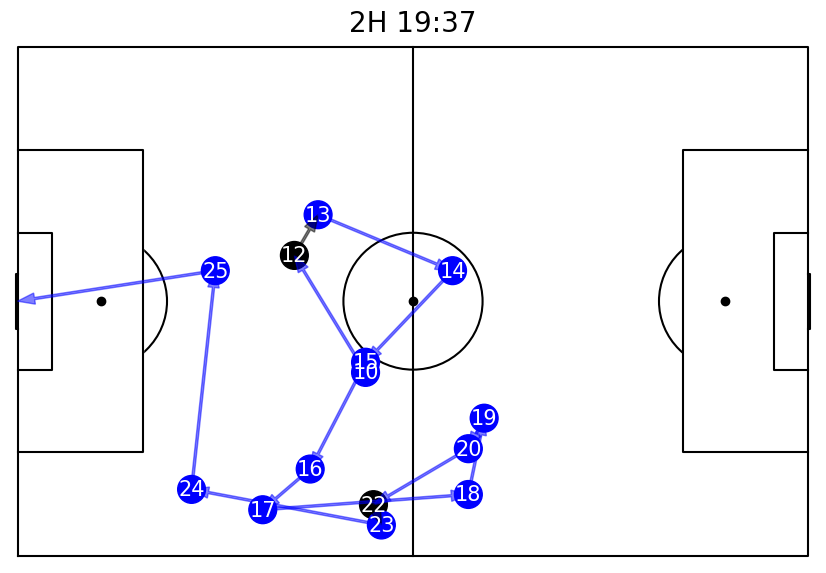

,display_time,team_name,player_name,event_type,sub_event_type,tags
1010,2H 19:08,France,B. Matuidi,Pass,Simple pass,[Accurate]
1011,2H 19:10,France,A. Griezmann,Duel,Ground attacking duel,"[Neutral, Accurate]"
1012,2H 19:10,Croatia,M. Brozović,Duel,Ground defending duel,"[Neutral, Accurate]"
1013,2H 19:12,France,A. Griezmann,Pass,Simple pass,[Accurate]
1014,2H 19:14,France,S. N'Zonzi,Pass,Simple pass,[Accurate]
1015,2H 19:16,France,P. Pogba,Pass,Simple pass,[Accurate]
1016,2H 19:20,France,L. Hernández,Pass,Simple pass,[Accurate]
1017,2H 19:21,France,B. Matuidi,Pass,Simple pass,[Accurate]
1018,2H 19:24,France,P. Pogba,Pass,Simple pass,[Accurate]
1019,2H 19:25,France,S. N'Zonzi,Pass,Simple pass,[Accurate]


In [28]:
first_idx = seq_records.at[seq_id, 'first_idx']
last_idx = seq_records.at[seq_id, 'last_idx']
visualize_sequence(match_events, first_idx, last_idx)